In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd

In [2]:
plt.matplotlib.__version__, np.__version__, sklearn.__version__, pd.__version__

('2.1.0', '1.16.2', '0.19.1', '0.24.1')

In [3]:
root_dir = os.path.abspath("__file__"+"/../../")

In [4]:
sys.path.insert(0,root_dir)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import dsutil

In [7]:
dsutil.__version__

'0.0.11'

In [8]:
from dsutil import plotting

## simplest possible example, default options

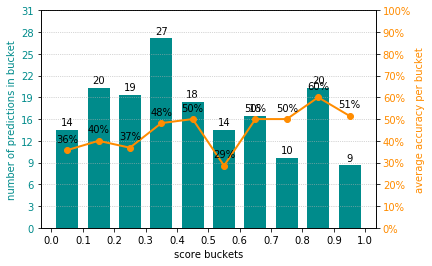

In [13]:
# np.random.seed(100)
scores = np.random.normal(size=500)
actual_values = np.random.choice([0,1.0],500)

plotting.calibration_accuracy_plot(actual_values, scores)

## example: model with good calibration, but low accuracy

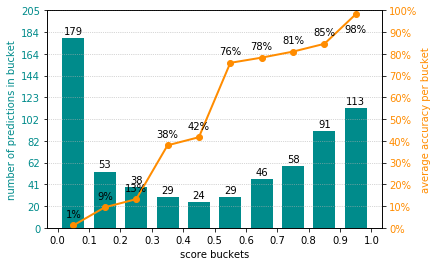

In [14]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(3)

X, y = make_classification(n_samples=2000, n_features=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = LogisticRegression()
clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]

plotting.calibration_accuracy_plot(y_test, y_pred)

## example: badly calibrated model, high accuracy

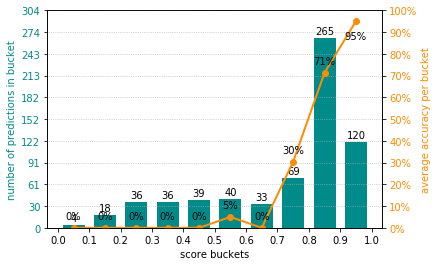

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

np.random.seed(3)

X, y = make_classification(n_samples=2000, n_features=5, class_sep=0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)

y_pred_raw = clf.decision_function(X_test)
# need to normalize the scores because decision_function outputs absolute values
# and reshape so it's a column vector
y_pred = MinMaxScaler().fit_transform(y_pred_raw.reshape(-1,1)).ravel()

plotting.calibration_accuracy_plot(y_test, y_pred)

## example: very badly calibrated model, low accuracy

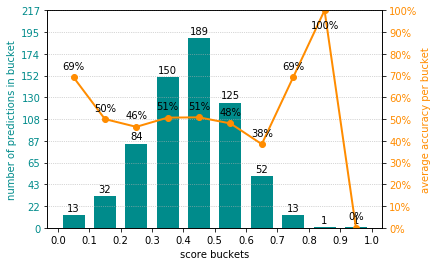

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

np.random.seed(3)

X, y = make_classification(n_samples=2000, n_features=5, class_sep=0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = SVC(kernel='linear')
clf.fit(X_train,y_train)

y_pred_raw = clf.decision_function(X_test)
# need to normalize the scores because decision_function outputs absolute values
# and reshape so it's a column vector
y_pred = MinMaxScaler().fit_transform(y_pred_raw.reshape(-1,1)).ravel()

plotting.calibration_accuracy_plot(y_test, y_pred)